<a href="https://colab.research.google.com/github/regulate-tech/nhstech/blob/main/subject-paper/nhstech_project_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# GOAL: create a dataset we can use to analyse spending on storing paper medical records in the NHS

# CONTEXT: the NHS has committed to replacing paper medical records with digital records several times but this has not happened.
# CONTEXT: one way to understand the gap between commitment and delivery is to look at spending on storing and using paper records.
# CONTEXT: all NHS Trusts have to complete an annual return for their estate costs which includes data on paper records costs.

# STEP 1 - go to the master index page for the estates annual returns and find the sub-pages for each year's returns.

# NB: our usual scraping method uses requests to fetch web pages and BeautifulSoup to extract links and data from the pages
import requests
from bs4 import BeautifulSoup

def extract_annual_return_links():
  """
  Extracts links to annual return sub pages from the NHS Estates Returns page.
  """
# NB: The live NHS site will give a 403 error if it thinks it is being scraped.
# We can use a cached version instead as the page updates only rarely.
  cache_url = "http://webcache.googleusercontent.com/search?q=cache:"
  target_url = "https://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection"

  response = requests.get(cache_url + target_url)
  soup = BeautifulSoup(response.content, "html.parser")

# The naming of the links to the annual return pages are inconsistent but we can look for a YYYY-YY pattern to identify them
# We create an array with the values 2017-18 through to 2026-27 to pick up the right pages.
# NB We may need to update this as new returns are added if they change the format again.
# NB There are returns earlier than 2017-18 but these don't contain medical records costs

  years = ["20" + str(i) + "-" + str(i+1) for i in range(17, 27)]

  links = []

  for link in soup.find_all("a"):
    href = link.get("href")

    for year in years:
      if year in href:
        print('FOUND: ' + year)
        links.append(href)

  return links

# Get the links
links = extract_annual_return_links()

# We write the links to a file.
url_root = "http://digital.nhs.uk"

# Join the url_root and links
full_links = [url_root + link for link in links]

# We can print the links to confirm this looks sensible
print(full_links)

# Write the full links to a file
with open('full_links.txt', 'w') as f:
  for link in full_links:
    f.write(link + '\n')

FOUND: 2023-24
FOUND: 2023-24
FOUND: 2022-23
FOUND: 2021-22
FOUND: 2020-21
FOUND: 2019-20
FOUND: 2018-19
FOUND: 2017-18
['http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/management-information---provisional-summary-figures-for-2023-24', 'http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/summary-page-and-dataset-for-eric-2023-24', 'http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/england-2022-23', 'http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/england-2021-22', 'http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/england-2020-21', 'http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/england-2019-20', 'http://digital.nhs.uk/data-and-information/publ

In [47]:
#STEP 2 - for each annual return page we pull the csv file links

import requests
from bs4 import BeautifulSoup

# We can use the Google cache version for these static pages.
cache_url = "http://webcache.googleusercontent.com/search?q=cache:"

# Read the links from the file
with open('full_links.txt', 'r') as f:
  links = [line.strip() for line in f]

# Function to extract CSV links from a page
def extract_csv_links(url):
  """
  Extracts links to CSV files from a given URL.
  """
  response = requests.get(cache_url + url)
  soup = BeautifulSoup(response.content, "html.parser")
  csv_links = []
  for link in soup.find_all("a"):
    href = link.get("href")
    if href and href.endswith(".csv"):
      csv_links.append(href)
  return csv_links

# Open a file to write the CSV links
with open('csv_links.txt', 'w') as f:

  # Iterate over the links and extract CSV links
  for link in links:
    csv_links = extract_csv_links(link)
    print(f"Found {len(csv_links)} CSV links on {link}")
    for csv_link in csv_links:
      # Write each CSV link to the file
      f.write(csv_link + '\n')
      print(csv_link)


Found 0 CSV links on http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/management-information---provisional-summary-figures-for-2023-24
Found 0 CSV links on http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/summary-page-and-dataset-for-eric-2023-24
Found 3 CSV links on http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/england-2022-23
https://files.digital.nhs.uk/FB/BE3AC8/ERIC%20-%20202223%20-%20Trust%20data.csv
https://files.digital.nhs.uk/41/5787C9/ERIC%20-%202022_23%20-%20Site%20data.csv
https://files.digital.nhs.uk/42/D5A005/ERIC%20-%202022_23%20-%20PFI%20data.csv
Found 3 CSV links on http://digital.nhs.uk/data-and-information/publications/statistical/estates-returns-information-collection/england-2021-22
https://files.digital.nhs.uk/08/84C46C/ERIC%20-%20202122%20-%20Trust%20data.csv
https://files.digital.nhs.uk/E

In [48]:
# STEP 3 - fetch a local copy of each of the csv files

import requests
import os

# Read the CSV links from the file
with open('csv_links.txt', 'r') as f:
  csv_links = [line.strip() for line in f]

# Create a directory to store the CSV files
if not os.path.exists('csv_files'):
  os.makedirs('csv_files')

# Iterate over the CSV links and download the files
for link in csv_links:
  try:
    response = requests.get(link)
    response.raise_for_status()  # Raise an exception for bad status codes

    # Extract the filename from the URL
    filename = link.split('/')[-1]

    # Save the file to the 'csv_files' directory
    filepath = os.path.join('csv_files', filename)
    with open(filepath, 'wb') as f:
      f.write(response.content)
    print(f"Downloaded: {filename}")

  except requests.exceptions.RequestException as e:
    print(f"Error downloading {link}: {e}")


Downloaded: ERIC%20-%20202223%20-%20Trust%20data.csv
Downloaded: ERIC%20-%202022_23%20-%20Site%20data.csv
Downloaded: ERIC%20-%202022_23%20-%20PFI%20data.csv
Downloaded: ERIC%20-%20202122%20-%20Trust%20data.csv
Downloaded: ERIC%20-%20202122%20-%20Site%20Data%20v3.csv
Downloaded: ERIC%20-%20202122%20-%20PFI%20data%20-%20v2.csv
Downloaded: ERIC%20-%20202021%20-%20Trust%20data.csv
Downloaded: ERIC%20-%20202021%20-%20Site%20data%20v2.csv
Downloaded: ERIC%20-%20202021%20-%20PFI%20data.csv
Downloaded: ERIC%20-%20201920%20-%20TrustData.csv
Downloaded: ERIC%20-%20201920%20-%20SiteData%20-%20v2.csv
Downloaded: ERIC%20-%20201920%20-%20PFIData.csv
Downloaded: ERIC%20-%20201819%20-%20TrustData%20v4.csv
Downloaded: ERIC%20-%20201819%20-%20SiteData%20v4.csv
Downloaded: ERIC%20-%20201819%20-%20PFIData%20v3.csv
Downloaded: ERIC-201718-TrustData.csv
Downloaded: ERIC-201718-SiteData.csv
Downloaded: ERIC-201718-PFIData.csv


In [49]:
# STEP 4 - clean up filenames of downloaded .csv files to replace any instances of '%20' with '-'

import os

# Get a list of all CSV files in the 'csv_files' directory
csv_files = [f for f in os.listdir('csv_files') if f.endswith('.csv')]

# Iterate over the CSV files and rename them
for filename in csv_files:
  new_filename = filename.replace('%20', '-')
  if new_filename != filename:
    old_filepath = os.path.join('csv_files', filename)
    new_filepath = os.path.join('csv_files', new_filename)
    os.rename(old_filepath, new_filepath)
    print(f"Renamed '{filename}' to '{new_filename}'")

Renamed 'ERIC%20-%20201819%20-%20PFIData%20v3.csv' to 'ERIC---201819---PFIData-v3.csv'
Renamed 'ERIC%20-%20201819%20-%20SiteData%20v4.csv' to 'ERIC---201819---SiteData-v4.csv'
Renamed 'ERIC%20-%20202021%20-%20Trust%20data.csv' to 'ERIC---202021---Trust-data.csv'
Renamed 'ERIC%20-%20202122%20-%20PFI%20data%20-%20v2.csv' to 'ERIC---202122---PFI-data---v2.csv'
Renamed 'ERIC%20-%20202122%20-%20Site%20Data%20v3.csv' to 'ERIC---202122---Site-Data-v3.csv'
Renamed 'ERIC%20-%20201920%20-%20PFIData.csv' to 'ERIC---201920---PFIData.csv'
Renamed 'ERIC%20-%20201819%20-%20TrustData%20v4.csv' to 'ERIC---201819---TrustData-v4.csv'
Renamed 'ERIC%20-%20202021%20-%20Site%20data%20v2.csv' to 'ERIC---202021---Site-data-v2.csv'
Renamed 'ERIC%20-%202022_23%20-%20PFI%20data.csv' to 'ERIC---2022_23---PFI-data.csv'
Renamed 'ERIC%20-%20202021%20-%20PFI%20data.csv' to 'ERIC---202021---PFI-data.csv'
Renamed 'ERIC%20-%202022_23%20-%20Site%20data.csv' to 'ERIC---2022_23---Site-data.csv'
Renamed 'ERIC%20-%20201920%20

In [50]:
# STEP 5 - check if each .csv filename uses the format YYYYYY or YYYY_YY and change any that have '_' to the format without this

import os

# Get a list of all CSV files in the 'csv_files' directory
csv_files = [f for f in os.listdir('csv_files') if f.endswith('.csv')]

# Iterate over the CSV files and rename them
for filename in csv_files:
  # Check if the filename contains '_'
  if "_" in filename:
    # Split the filename by '_'
    parts = filename.split("_")
    # Combine the parts to create the new filename
    new_filename = parts[0] + parts[1]
    # Rename the file
    old_filepath = os.path.join('csv_files', filename)
    new_filepath = os.path.join('csv_files', new_filename)
    os.rename(old_filepath, new_filepath)
    print(f"Renamed '{filename}' to '{new_filename}'")


Renamed 'ERIC---2022_23---Site-data.csv' to 'ERIC---202223---Site-data.csv'
Renamed 'ERIC---2022_23---PFI-data.csv' to 'ERIC---202223---PFI-data.csv'


In [51]:
# STEP 6 - change the encoding system of any files in the csv_files directory to UTF-8 where it is not currently in that format
# NB we do this because the read_csv function in pandas can fall over if the encoding is unexpected

import chardet
import os

# Get a list of all CSV files in the 'csv_files'
csv_files = [f for f in os.listdir('csv_files') if f.endswith('.csv')]

# Iterate over the CSV files and identify the encoding
for filename in csv_files:
  filepath = os.path.join('csv_files', filename)
  with open(filepath, 'rb') as f:
    rawdata = f.read()
  result = chardet.detect(rawdata)
  encoding = result["encoding"]

  # If the encoding is not UTF-8, convert it to UTF-8
  if encoding != 'utf-8':
    try:
      with open(filepath, 'r', encoding=encoding) as f:
        data = f.read()
      with open(filepath, 'w', encoding='utf-8') as f:
        f.write(data)
      print(f'{filename}: Converted from {encoding} to UTF-8')
    except Exception as e:
      print(f"Error converting {filename}: {e}")
  else:
    print(f'{filename}: Already in UTF-8')


ERIC---202223---PFI-data.csv: Converted from UTF-8-SIG to UTF-8
ERIC---201819---PFIData-v3.csv: Converted from ISO-8859-1 to UTF-8
ERIC---202122---Site-Data-v3.csv: Converted from Windows-1252 to UTF-8
ERIC---201920---SiteData---v2.csv: Converted from Windows-1252 to UTF-8
ERIC-201718-PFIData.csv: Converted from ISO-8859-1 to UTF-8
ERIC---202122---PFI-data---v2.csv: Converted from Windows-1252 to UTF-8
ERIC---201920---PFIData.csv: Converted from Windows-1252 to UTF-8
ERIC-201718-SiteData.csv: Converted from Windows-1252 to UTF-8
ERIC---202021---Trust-data.csv: Converted from ISO-8859-1 to UTF-8
ERIC---201819---TrustData-v4.csv: Converted from ISO-8859-1 to UTF-8
ERIC---202021---PFI-data.csv: Converted from Windows-1252 to UTF-8
ERIC---202122---Trust-data.csv: Converted from UTF-8-SIG to UTF-8
ERIC---202021---Site-data-v2.csv: Converted from Windows-1252 to UTF-8
ERIC-201718-TrustData.csv: Converted from ISO-8859-1 to UTF-8
ERIC---202223---Site-data.csv: Converted from Windows-1252 to U

In [52]:
# STEP 7 - Open.csv files in the csv_files directory that have 'Trust' in their filename.
# Create a dictionary with a row for each unique 'Trust Code' and 'Trust Name' in the csv file.
# Create a year code variable by finding a pattern like '202223' in the filename.
# Extract data from any columns that contain 'Medical Records' and store this against the correct 'Trust Code'
# with the column name plus year code.

import os
import pandas as pd
import re

def process_csv_files():
  """
  Opens CSV files in the 'csv_files' directory that have 'Trust' in their filename,
  creates a dictionary with unique 'Trust Code' and 'Trust Name' pairings,
  extracts data from columns containing 'Medical Records', and stores it with the
  column name plus year code.
  """
  trust_data = {}

  # Get a list of all CSV files in the 'csv_files' directory that contain 'Trust'
  csv_files = [f for f in os.listdir('csv_files') if f.endswith('.csv') and "Trust" in f]

  # Iterate over the CSV files
  for filename in csv_files:
    filepath = os.path.join('csv_files', filename)

    # Extract year code from filename
    year_code = re.search(r'(\d{6})', filename)
    if year_code:
      year_code = year_code.group(1)
    else:
      year_code = "Unknown"  # Default value if no year code found

    try:
      # Read the CSV file into a pandas DataFrame
      df = pd.read_csv(filepath)

      # Check if the DataFrame has columns named "Trust Code" and "Trust Name"
      if "Trust Code" in df.columns and "Trust Name" in df.columns:
        # Iterate through the rows of the DataFrame
        for index, row in df.iterrows():
          trust_code = row["Trust Code"]
          trust_name = row["Trust Name"]
          # Add the pairing to the dictionary if it doesn't already exist
          if (trust_code, trust_name) not in trust_data:
            trust_data[(trust_code, trust_name)] = {}

          # Extract data from columns containing 'Medical Records'
          for col in df.columns:
            if "Medical Records" in col:
              # Store the data with the column name plus year code
              trust_data[(trust_code, trust_name)][col + "_" + year_code] = row[col]

    except Exception as e:
      print(f"Error processing file {filename}: {e}")

  return trust_data

# Call the function to process the CSV files
trust_data = process_csv_files()

# We can print the trust_data dictionary
# print(trust_data)

# Convert the trust_data dictionary to a DataFrame
trust_df = pd.DataFrame.from_dict(trust_data, orient='index')
trust_df = trust_df.reset_index()

# Rename the index columns
trust_df = trust_df.rename(columns={'level_0': 'trust_code', 'level_1': 'trust_name'})

# Rename columns to simpler format
trust_df.columns = trust_df.columns.str.replace(r'Medical Records cost - Onsite \(£\)_(\d{6})', r'mrc_on_\1', regex=True)
trust_df.columns = trust_df.columns.str.replace(r'Medical Records cost - Offsite \(£\)_(\d{6})', r'mrc_off_\1', regex=True)
trust_df.columns = trust_df.columns.str.replace(r'Medical Records cost - Total \(£\)_(\d{6})', r'mrc_tot_\1', regex=True)
trust_df.columns = trust_df.columns.str.replace(r'Medical Records volume - Onsite \(records\)_(\d{6})', r'mrv_on_\1', regex=True)
trust_df.columns = trust_df.columns.str.replace(r'Medical Records volume - Offsite \(records\)_(\d{6})', r'mrv_off_\1', regex=True)
trust_df.columns = trust_df.columns.str.replace(r'Medical Records volume - Total \(records\)_(\d{6})', r'mrv_tot_\1', regex=True)

# Save the DataFrame to a CSV file
trust_df.to_csv('trust_annual_renamed.csv', index=False)


In [54]:
# STEP 8 - create a table from trust_annual_renamed listing each 'Trust Code' and 'Trust Name' and each column starting 'mrc' in ascending year order. write this table to a new .csv file.

import pandas as pd

# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_annual_renamed.csv')

# Select the desired columns
selected_columns = ['trust_code', 'trust_name'] + [col for col in trust_df.columns if col.startswith('mrc')]

# Create a new DataFrame with the selected columns
filtered_df = trust_df[selected_columns]

# Sort the columns by year
filtered_df = filtered_df.reindex(sorted(filtered_df.columns, key=lambda x: x.split('_')[-1] if '_' in x else x), axis=1)

# Replace null values with 0 to avoid errors when we add up values later
filtered_df.fillna(0, inplace=True)

# Save the DataFrame to a new CSV file
filtered_df.to_csv('trust_mrc_sorted.csv', index=False)


In [55]:
# STEP 8: format the data in trust_mrc_sorted_filled to remove commas from number fields

import pandas as pd

# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_mrc_sorted.csv')

# Select columns that contain numbers (excluding 'Trust Code' and 'Trust Name')
number_columns = [col for col in trust_df.columns if col not in ['trust_code', 'trust_name']]

# Remove commas from the number columns
trust_df[number_columns] = trust_df[number_columns].apply(lambda x: x.str.replace(',', ''))

# Convert the number columns to numeric
trust_df[number_columns] = trust_df[number_columns].apply(pd.to_numeric, errors='coerce')

# Save the DataFrame to a new CSV file
trust_df.to_csv('trust_mrc_sorted_formatted.csv', index=False)


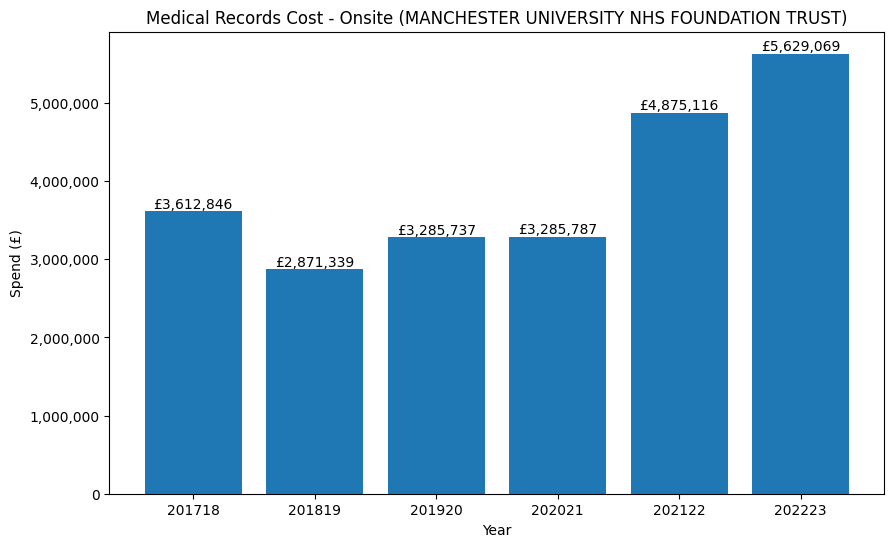

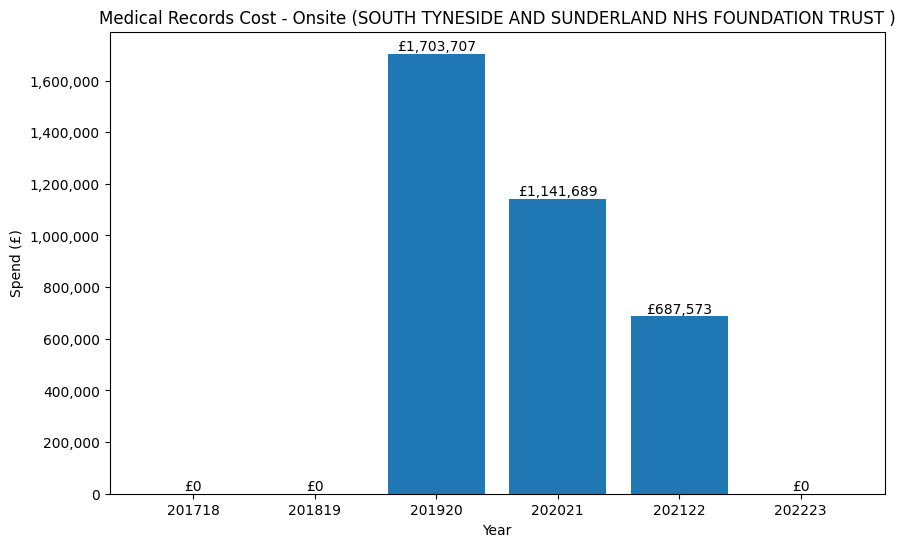

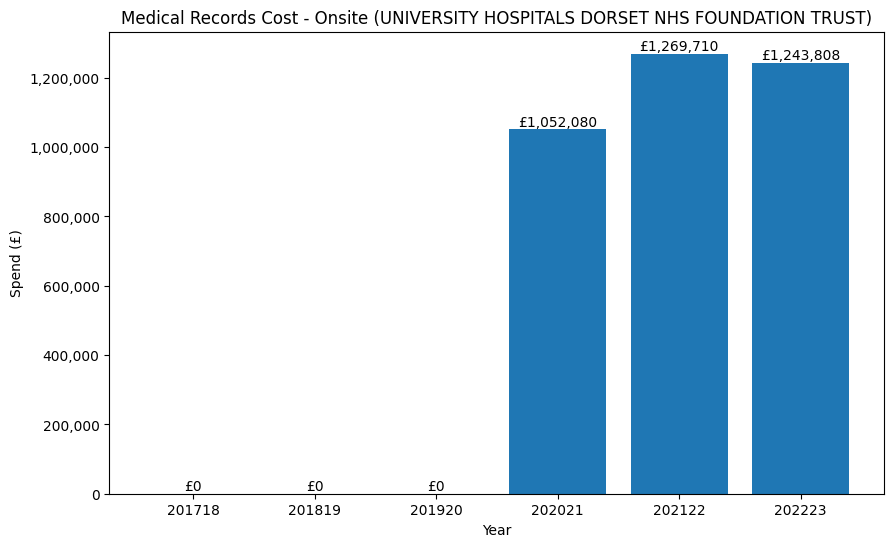

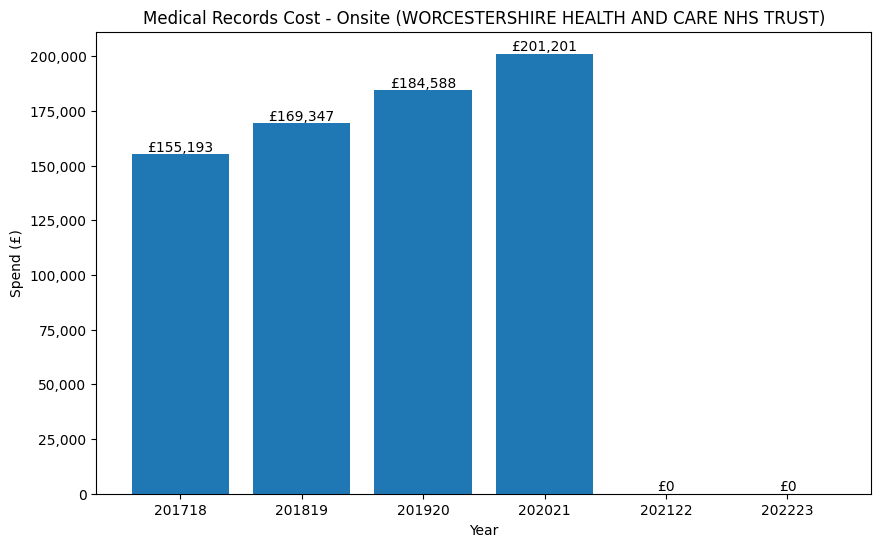

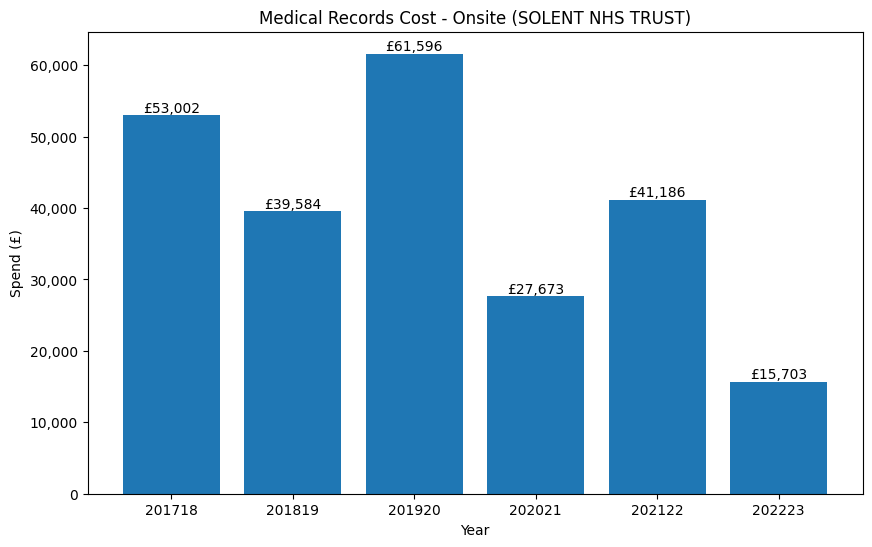

In [56]:
# STEP 9: we now have a csv file called trust_mrc_sorted_formatted with the medical records cost by Trust and Year.
# We can start to play with presenting this data in different formats.
# First, we create separate barcharts for each of the first 5 trusts showing their names
# and the annual spends on onsite storage

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_mrc_sorted_formatted.csv')

# TO test the function we can select the first 5 trusts
top_5_trusts = trust_df.head(5)

# Iterate over the top 5 trusts
for index, row in top_5_trusts.iterrows():
  # Extract the trust name
  trust_name = row['trust_name']

  # Select columns starting with 'mrc_on'
  mrc_on_columns = [col for col in trust_df.columns if col.startswith('mrc_on')]

  # Extract the year code from the column names
  years = [col.split('_')[-1] for col in mrc_on_columns]

  # Extract the values for the 'mrc_on' columns
  values = [row[col] for col in mrc_on_columns]

  # Create the bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(years, values)

  # Add labels and title
  plt.xlabel('Year')
  plt.ylabel('Spend (£)')
  plt.title(f'Medical Records Cost - Onsite ({trust_name})')

  # Format the y-axis values as currency
  plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

  # Set the baseline for the y-axis to 0
  plt.ylim(bottom=0)

  # Add values on the columns
  for i, v in enumerate(values):
    plt.text(i, v, f'£{v:,.0f}', ha='center', va='bottom')

  # Show the plot
  plt.show()


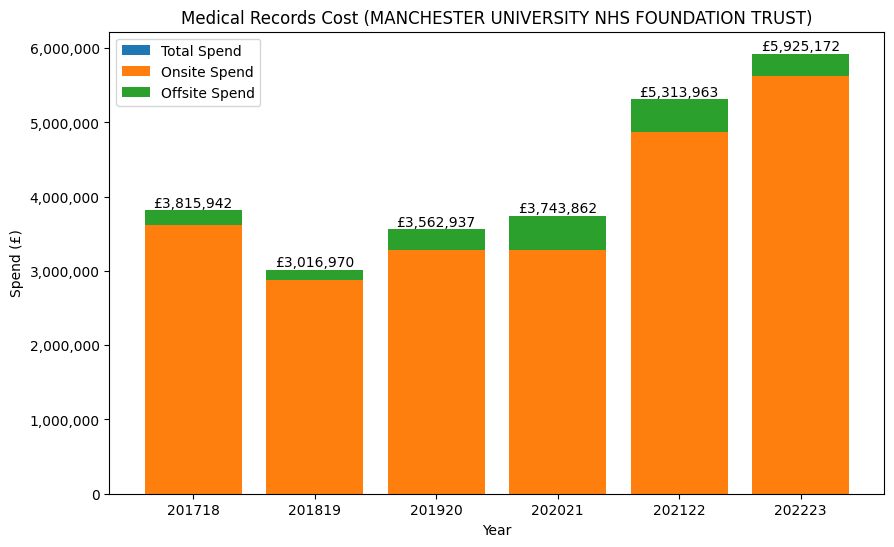

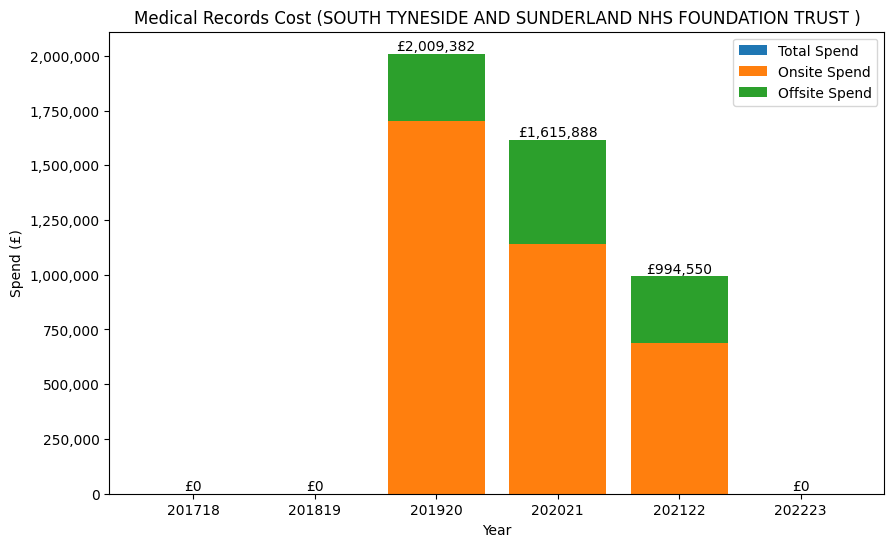

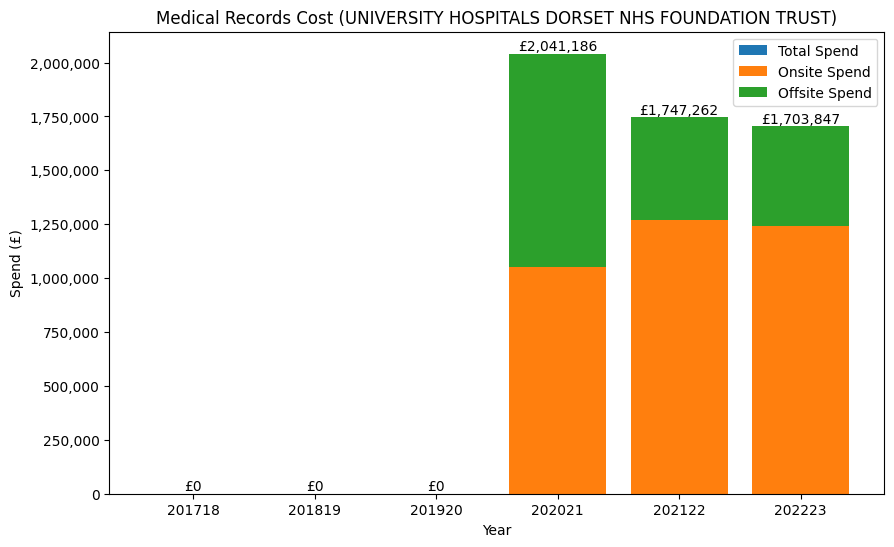

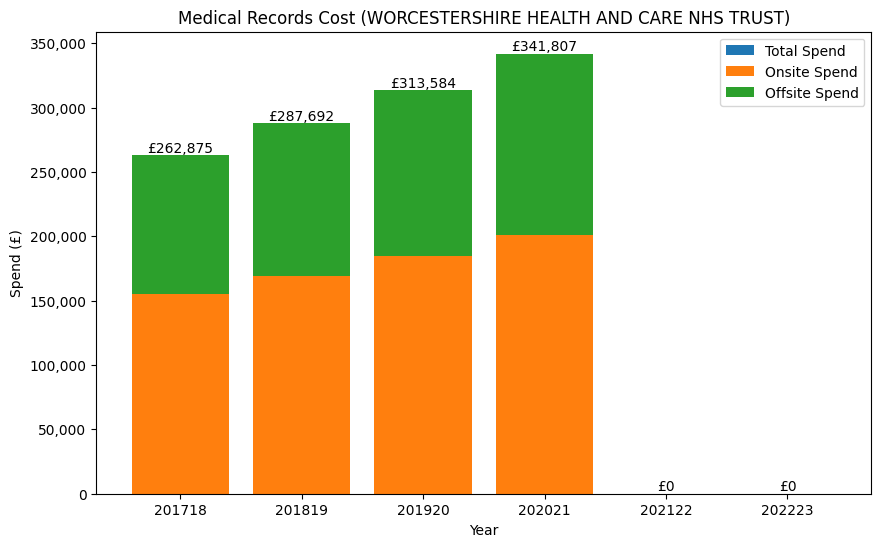

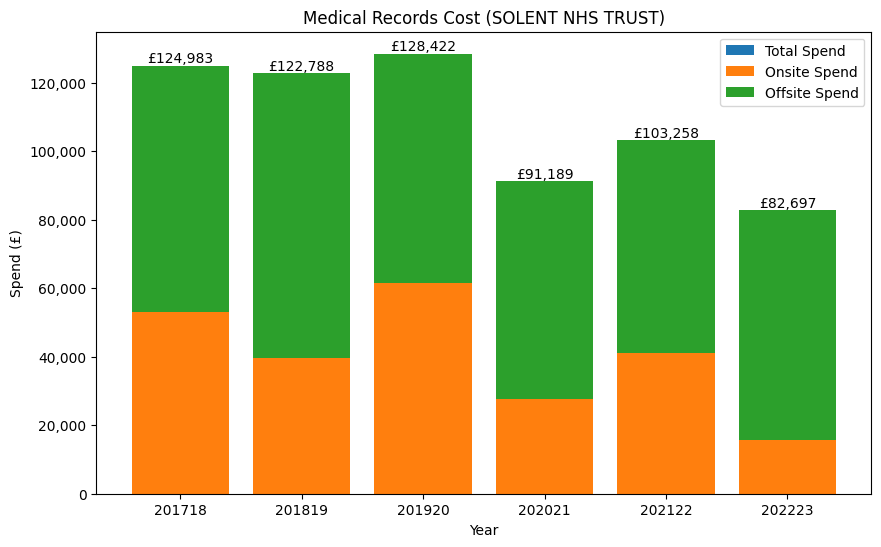

In [57]:
# STEP 10: Next, we use the file trust_mrc_sorted_formatted.csv to create separate barcharts for
# each of the first 5 trusts showing their names and the annual spends on all records storage

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_mrc_sorted_formatted.csv')

# Select the first 5 trusts
top_5_trusts = trust_df.head(5)

# Iterate over the top 5 trusts
for index, row in top_5_trusts.iterrows():
  # Extract the trust name
  trust_name = row['trust_name']

  # Select columns starting with 'mrc_on' or 'mrc_off'
  mrc_on_columns = [col for col in trust_df.columns if col.startswith('mrc_on')]
  mrc_off_columns = [col for col in trust_df.columns if col.startswith('mrc_off')]

  # Extract the year code from the column names
  years = [col.split('_')[-1] for col in mrc_on_columns]

  # Extract the values for the 'mrc_on' and 'mrc_off' columns
  mrc_on_values = [row[col] for col in mrc_on_columns]
  mrc_off_values = [row[col] for col in mrc_off_columns]
  mrc_total_values = [on + off for on, off in zip(mrc_on_values, mrc_off_values)]

  # Create the bar chart
  plt.figure(figsize=(10, 6))

  # Create bars for total spend
  plt.bar(years, mrc_total_values, label='Total Spend')

  # Create bars for onsite spend
  plt.bar(years, mrc_on_values, label='Onsite Spend')

  # Create bars for offsite spend
  plt.bar(years, mrc_off_values, bottom=mrc_on_values, label='Offsite Spend')

  # Add labels and title
  plt.xlabel('Year')
  plt.ylabel('Spend (£)')
  plt.title(f'Medical Records Cost ({trust_name})')

  # Format the y-axis values as currency
  plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

  # Set the baseline for the y-axis to 0
  plt.ylim(bottom=0)

  # Add values on the columns
  for i, v in enumerate(mrc_total_values):
    plt.text(i, v, f'£{v:,.0f}', ha='center', va='bottom')

  # Add legend
  plt.legend()

  # Show the plot
  plt.show()


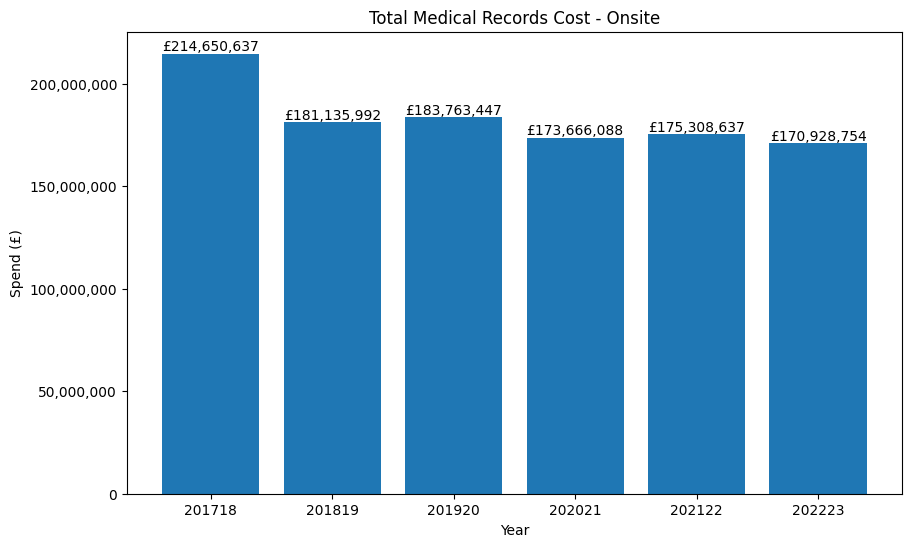

In [58]:
# STEP 11: Now, we use the file trust_mrc_sorted_filled_formatted.csv to create a barchart
# showing the sum of the spend on onsite records storage by year for all trusts.

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_mrc_sorted_formatted.csv')

# Select columns starting with 'mrc_on'
mrc_on_columns = [col for col in trust_df.columns if col.startswith('mrc_on')]

# Extract the year code from the column names
years = [col.split('_')[-1] for col in mrc_on_columns]

# Calculate the sum of spend by year
total_spend_by_year = trust_df[mrc_on_columns].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, total_spend_by_year)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Spend (£)')
plt.title('Total Medical Records Cost - Onsite')

# Format the y-axis values as currency
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Set the baseline for the y-axis to 0
plt.ylim(bottom=0)

# Add values on the columns
for i, v in enumerate(total_spend_by_year):
  plt.text(i, v, f'£{v:,.0f}', ha='center', va='bottom')

# Show the plot
plt.show()


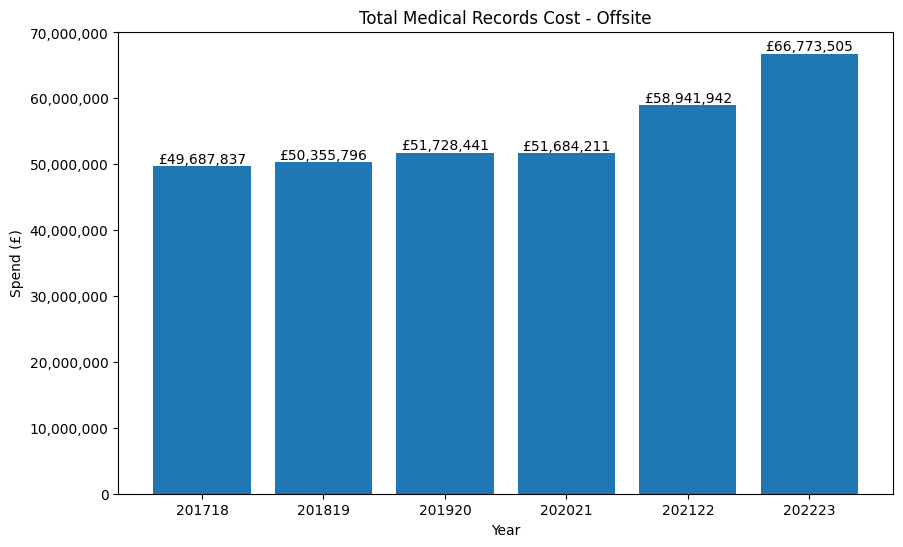

In [59]:
# STEP 12: Now, we use the file trust_mrc_sorted_filled_formatted.csv to create a barchart
# showing the sum of the spend on offsite records storage by year for all trusts.

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_mrc_sorted_formatted.csv')

# Select columns starting with 'mrc_off'
mrc_off_columns = [col for col in trust_df.columns if col.startswith('mrc_off')]

# Extract the year code from the column names
years = [col.split('_')[-1] for col in mrc_off_columns]

# Calculate the sum of spend by year
total_spend_by_year = trust_df[mrc_off_columns].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, total_spend_by_year)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Spend (£)')
plt.title('Total Medical Records Cost - Offsite')

# Format the y-axis values as currency
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Set the baseline for the y-axis to 0
plt.ylim(bottom=0)

# Add values on the columns
for i, v in enumerate(total_spend_by_year):
  plt.text(i, v, f'£{v:,.0f}', ha='center', va='bottom')

# Show the plot
plt.show()


In [60]:
# STEP 13: create new columns showing the total for onsite and offsite records storage

import pandas as pd
# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_mrc_sorted_formatted.csv')

# Select columns starting with 'mrc_on_'
mrc_on_columns = [col for col in trust_df.columns if col.startswith('mrc_on_')]

# Extract the last 6 characters from the column names
year_codes = [col[-6:] for col in mrc_on_columns]
print(year_codes)

for year_code in year_codes:
  trust_df['mrc_total_' + year_code] = trust_df['mrc_on_' + year_code] + trust_df['mrc_off_' + year_code]

# Save the DataFrame to a new CSV file
trust_df.to_csv('trust_mrc_total_added.csv', index=False)



['201718', '201819', '201920', '202021', '202122', '202223']


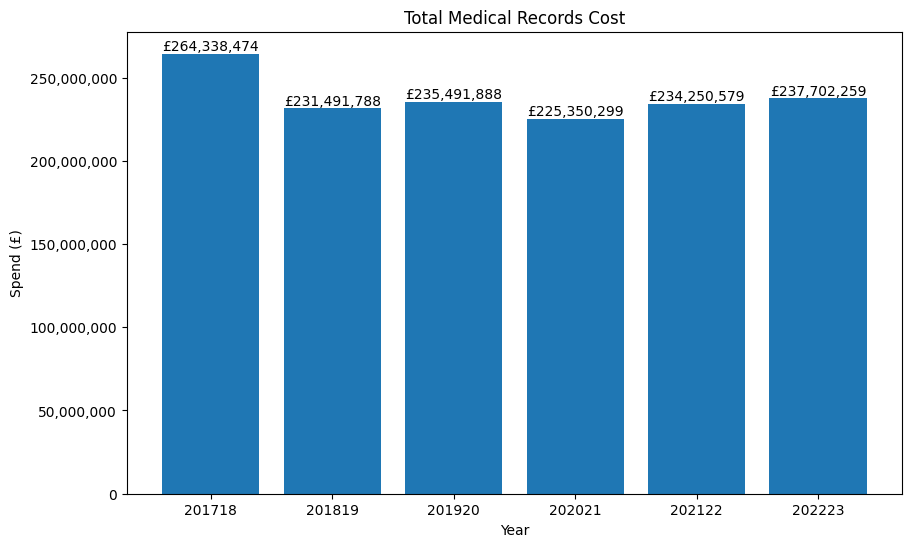

In [61]:
# STEP 14: Use trust_mrc_total_added.csv to create a bar chart
# showing the total cost for records storage by year

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
trust_df = pd.read_csv('trust_mrc_total_added.csv')

# Select columns starting with 'mrc_total'
mrc_total_columns = [col for col in trust_df.columns if col.startswith('mrc_total')]

# Extract the year code from the column names
years = [col.split('_')[-1] for col in mrc_total_columns]

# Calculate the sum of spend by year
total_spend_by_year = trust_df[mrc_total_columns].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(years, total_spend_by_year)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Spend (£)')
plt.title('Total Medical Records Cost')

# Format the y-axis values as currency
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Set the baseline for the y-axis to 0
plt.ylim(bottom=0)

# Add values on the columns
for i, v in enumerate(total_spend_by_year):
  plt.text(i, v, f'£{v:,.0f}', ha='center', va='bottom')

# Show the plot
plt.show()
